In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from pyqtorch.core.circuit import QuantumCircuit
from pyqtorch.ansatz import AlternateLayerAnsatz
from pyqtorch.embedding import SingleLayerEncoding
from pyqtorch.core.operation import Z, RX
import math

In [11]:
def target_function(x, function=None, factor=1, degree=1):
    """Defining a function that takes in x, function, factor, and degree.
    It then returns a result.  If function is None, it will return a
    trigonometric function. If function is not None, it will return a custom
    function.

    Args:
        x (_type_): _description_ function (_type_, optional): _description_.
        Defaults to None. factor (int, optional): _description_. Defaults to 1.
        degree (int, optional): _description_. Defaults to 3.

    Returns:
        _type_: _description_
    """
    result = 0
    if function == None:
        # some trigo function
        for i in range(degree):
            result += torch.cos(i * x) + torch.sin(i * x)
        result *= factor
    else:
        # custom function
        result = factor * function(x)

    return result

In [12]:
# Creating a dictionary with keys that are strings and values that are functions.
FUNCTIONS = {
    "0": None,
    "1": lambda a: 2 * a,
    "2": lambda a: a**2,
    "3": lambda a: a**3,
    "4": math.cos,
    "5": math.sin,
    "6": math.tan,
}
FUNCTION = "1"
function = FUNCTIONS[FUNCTION]
factor = 1.0  # 0.015
degree = 5

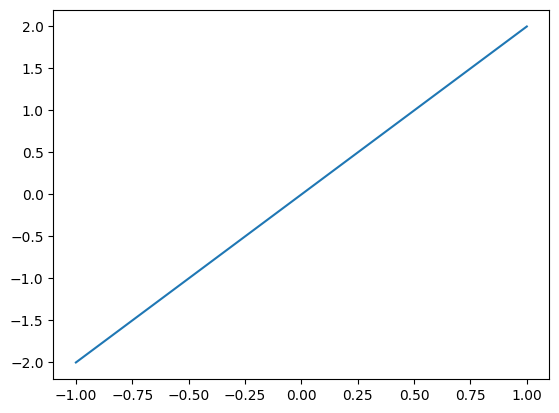

In [13]:
# Plotting the target function.
x = torch.tensor(np.linspace(-1, 1, 100))  # has to be -1, 1 interval for Cheb.
target_y = target_function(x, function=function, factor=factor, degree=degree)
plt.plot(x.numpy(), target_y.numpy())

In [14]:
# Different feature maps and rotations bloacks.

from pyqtorch.core.operation import batchedRY
from pyqtorch.core.circuit import QuantumCircuit


class SingleLayerRyEncoding(QuantumCircuit):
    """
    Single layer quantum circuit for encoding a single layer quantum circuit.
    """

    def __init__(self, n_qubits):
        super().__init__(n_qubits)

    def forward(self, state, x):
        for i in range(self.n_qubits):
            state = batchedRY(x, state, [i], self.n_qubits)
        return state


class ChebychevTowerEncoding(QuantumCircuit):
    """
    Quantum circuit for the Chebychev Tower encoding.
    """

    def __init__(self, n_qubits):
        super().__init__(n_qubits)

    def forward(self, state, x):
        for i in range(self.n_qubits):
            state = batchedRY(
                torch.tensor(i, dtype=torch.float64) * torch.arccos(x),
                state,
                [i],
                self.n_qubits,
            )
        return state


class ChebychevSparseEncoding(QuantumCircuit):
    """
    Quantum circuit for the Chebychev Sparse encoding.
    """

    def __init__(self, n_qubits):
        super().__init__(n_qubits)

    def forward(self, state, x):
        for i in range(self.n_qubits):
            state = batchedRY(
                torch.arccos(x),
                state,
                [i],
                self.n_qubits,
            )
        return state


from pyqtorch.core.operation import U


class SingleQubitRotation(QuantumCircuit):
    """
    Quantum circuit for the single qubit rotation.
    """

    def __init__(self, n_qubits, arbitrary=False):
        super().__init__(n_qubits)
        self.theta = nn.Parameter(torch.empty((self.n_qubits, 3)))
        self.reset_parameters()
        self.arbitrary = arbitrary

    def reset_parameters(self):
        init.uniform_(self.theta, -2 * np.pi, 2 * np.pi)

    def forward(self, state):
        for i, t in enumerate(self.theta):
            state = U(t[0], t[1], t[2], state, [i], self.n_qubits)
        return state

In [15]:
class Model1(QuantumCircuit):
    """Model with no feature map function."""

    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        # ansatzes
        if n_qubits == 1:
            self.ansatz1 = SingleQubitRotation(n_qubits, n_layers)
        else:
            self.ansatz1 = AlternateLayerAnsatz(n_qubits, n_layers)
        self.embedding = SingleLayerRyEncoding(n_qubits)
        # parameters
        self.param_coef = nn.Parameter(torch.tensor(1, dtype=torch.float64))
        self.param_offset = nn.Parameter(torch.tensor(1, dtype=torch.float64))

    def forward(self, x):
        batch_size = len(x)
        state = self.init_state(batch_size)

        state = self.ansatz1(state)
        state = self.embedding(state, x)

        # expectation value
        new_state = self.param_coef * Z(state, [0], self.n_qubits)

        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))

        return torch.real(
            torch.sum(torch.conj(state) * new_state, axis=0) + self.param_offset
        )


class Model2(QuantumCircuit):
    """Model with feature map function."""

    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        # ansatzes
        self.ansatz1 = SingleQubitRotation(n_qubits, arbitrary=False)
        self.embedding = ChebychevSparseEncoding(n_qubits)
        # parameters
        self.param_coef = nn.Parameter(torch.tensor(1, dtype=torch.float64))
        self.param_offset = nn.Parameter(
            torch.tensor(1e-5, dtype=torch.float64)
        )

    def forward(self, x):
        batch_size = len(x)

        state = self.init_state(batch_size)
        state = self.ansatz1(state)
        state = self.embedding(state, x)

        # expectation value
        new_state = self.param_coef * Z(state, [0], self.n_qubits)

        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))

        return torch.real(
            torch.sum(torch.conj(state) * new_state, axis=0) + self.param_offset
        )

In [16]:
n_qubits = 1
n_layers = 1
model = Model2(n_qubits, n_layers)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10_000

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = F.mse_loss(target_y, y_pred)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss {loss}")

Epoch 1 | Loss 0.3903913952035643
Epoch 2 | Loss 0.3891040390036743
Epoch 3 | Loss 0.387822561498665
Epoch 4 | Loss 0.386546949484529
Epoch 5 | Loss 0.38527737134032525
Epoch 6 | Loss 0.38401398057496683
Epoch 7 | Loss 0.38275676349504795
Epoch 8 | Loss 0.38150595540621346
Epoch 9 | Loss 0.3802613885847681
Epoch 10 | Loss 0.37902339995616713
Epoch 11 | Loss 0.37779194998574
Epoch 12 | Loss 0.3765671689153718
Epoch 13 | Loss 0.37534902308680995
Epoch 14 | Loss 0.3741376238313775
Epoch 15 | Loss 0.372933012941163
Epoch 16 | Loss 0.37173533163373
Epoch 17 | Loss 0.370544601407725
Epoch 18 | Loss 0.36936075371324434
Epoch 19 | Loss 0.368183908507852
Epoch 20 | Loss 0.3670140599595403
Epoch 21 | Loss 0.36585129579245923
Epoch 22 | Loss 0.36469558628035165
Epoch 23 | Loss 0.3635469786406967
Epoch 24 | Loss 0.3624054691056033
Epoch 25 | Loss 0.3612710980201285
Epoch 26 | Loss 0.3601438046783418
Epoch 27 | Loss 0.3590236211268633
Epoch 28 | Loss 0.3579105360246505
Epoch 29 | Loss 0.35680456871

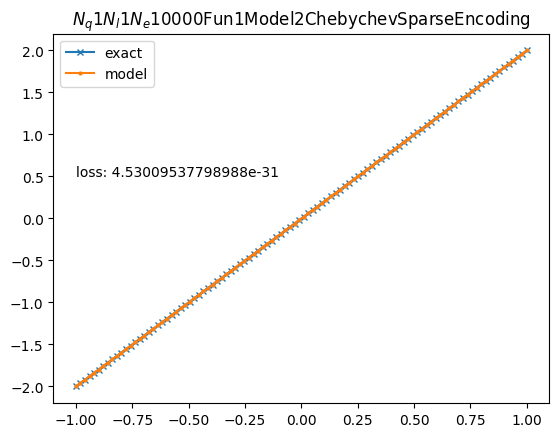

In [18]:
with torch.no_grad():
    y = model(x)

# Plotting the exact function and the model function.
plt.plot(x.numpy(), target_y.numpy(), label="exact", marker="x", markersize=4)
plt.plot(x.numpy(), y.numpy(), label="model", marker="o", markersize=2)
plt.legend()
plt.title(
    f"$N_q{n_qubits}N_l{n_layers}N_e{epochs}$Fun{FUNCTION}{model.__class__.__name__}"
    f"{model.embedding.__class__.__name__}"
)
plt.text(-1, 0.5, f"loss: {loss.detach().numpy()}")
# plot text in the plot
plt.show()

In [19]:
# Print parameters.
for ps in model.parameters():
    print(ps)

Parameter containing:
tensor(2.0000, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(1.1398e-16, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[1.7744e+00, 3.7499e-16, 1.0460e+00]], requires_grad=True)


***
# Outcome:
- On a single qubit we can fit a linear function if Chebychev map is used.
- One can test that then the model generalizes outside the training interval.